In [4110]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [4111]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/train.csv')
df_test = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/test.csv')

Let's first compare the two datasets to ensure there is consistency between them and determine what cleaning we need to do.

In [4112]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4113]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4115]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Both datasets are missing well over 10% of the Cabin data, so I will drop this column. For the Age column, this data will likely be important so I want to keep the column. I will fill the missing volues with the mean age based on the Sex of the person. I will fill the missing Embarked values with the mode, and the missing Fare amounts with the mean per corresponding Pclass.

In [4116]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [4117]:
def clean_data(df):
    df = df.drop(['Cabin', 'Ticket'], axis=1)
    df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('mean'))
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
                
    return df

There are a few additional columns I want to make as well. First, the name columns tend to have some titles associated with them which could provide info on the perceived importance or social rank of a person, which could impact their survival rate. I want to extract that title and set it as a new value in the dataframe.

In [4118]:
def create_title_column(df):
    df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()
    title_counts = df['Title'].value_counts()
    rare_title = title_counts[title_counts < 10].index
    df['Title'] = df['Title'].replace(rare_title, 'Other')
    df = df.drop(['Name'], axis=1)
    
    return df


To make information a little more generalized, I want to bin some information such as age and fare amount. I noticed that certain age ranges have higher survival rates than others, so I want to try and bin these in a way that groups people into a bin with others who have similar survival rates. For fares, I'll bin based on 3 levels of high medium and low.

In [4119]:
def create_bins(df):
    bin_range = [0, 5, 10, 15, 30, 40, 50, 60, 70, 80]  
    labels = range(1, len(bin_range))
    df['Age_Bin'] = pd.cut(df['Age'], bins=bin_range, labels=labels).astype(int)
    df['Fare_Bin'] = pd.qcut(df['Fare'], q=3, labels=[1, 2, 3]).astype(int)

    return df

I also want a numerical representation of some of our categorical string variables. I will set those here:

In [4120]:
def encode_categorical_variables(df):
    label_encoder = LabelEncoder()
    df['Embarked_Code'] = label_encoder.fit_transform(df['Embarked'])
    df['Sex_Code'] = label_encoder.fit_transform(df['Sex'])
    df['Title_Code'] = label_encoder.fit_transform(df['Title'])
    return df


Now let's run our dataframes through these cleaning and pre-processing functions we defined above.

In [4121]:
df = clean_data(df)
df = create_title_column(df)
df = create_bins(df)
df = encode_categorical_variables(df)

In [4122]:
df_test = clean_data(df_test)
df_test = create_title_column(df_test)
df_test = create_bins(df_test)
df_test = encode_categorical_variables(df_test)

Let's check to make sure the cleaning was done properly on both sets.

In [4123]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
count,891.000000,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN,646,517,NaN,NaN,NaN,NaN,NaN
mean,446.000000,0.383838,2.308642,NaN,29.736034,0.523008,0.381594,32.204208,NaN,NaN,4.537598,1.985410,1.536476,0.647587,1.906846
std,257.353842,0.486592,0.836071,NaN,13.014897,1.102743,0.806057,49.693429,NaN,NaN,1.355592,0.822991,0.791503,0.477990,0.798361
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,7.910400,NaN,NaN,4.000000,1.000000,1.000000,0.000000,2.000000
50%,446.000000,0.000000,3.000000,NaN,30.000000,0.000000,0.000000,14.454200,NaN,NaN,4.000000,2.000000,2.000000,1.000000,2.000000
75%,668.500000,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,31.000000,NaN,NaN,5.000000,3.000000,2.000000,1.000000,2.000000


In [4124]:
df_test.describe(include='all')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
count,418.000000,418.000000,418,418.000000,418.000000,418.000000,418.000000,418,418,418.000000,418.000000,418.000000,418.000000,418.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,266,NaN,NaN,NaN,NaN,270,240,NaN,NaN,NaN,NaN,NaN
mean,1100.500000,2.265550,NaN,30.272597,0.447368,0.392344,35.571764,NaN,NaN,4.650718,1.964115,1.401914,0.636364,1.918660
std,120.810458,0.841838,NaN,12.634534,0.896760,0.981429,55.851997,NaN,NaN,1.268513,0.814234,0.854496,0.481622,0.788458
min,892.000000,1.000000,NaN,0.170000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,23.000000,0.000000,0.000000,7.895800,NaN,NaN,4.000000,1.000000,1.000000,0.000000,2.000000
50%,1100.500000,3.000000,NaN,30.272362,0.000000,0.000000,14.454200,NaN,NaN,5.000000,2.000000,2.000000,1.000000,2.000000
75%,1204.750000,3.000000,NaN,35.750000,1.000000,0.000000,31.471875,NaN,NaN,5.000000,3.000000,2.000000,1.000000,2.000000


In [4125]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,4,1,2,1,2
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,5,3,0,0,3
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,4,1,2,0,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,5,3,2,0,3
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,5,1,2,1,2


In [4126]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
0,892,3,male,34.5,0,0,7.8292,Q,Mr,5,1,1,1,2
1,893,3,female,47.0,1,0,7.0000,S,Mrs,6,1,2,0,3
2,894,2,male,62.0,0,0,9.6875,Q,Mr,8,2,1,1,2
3,895,3,male,27.0,0,0,8.6625,S,Mr,4,1,2,1,2
4,896,3,female,22.0,1,1,12.2875,S,Mrs,4,2,2,0,3


I want to visualize the data distribution of both datasets to check what kind of distribution the data has, but also check to see if both datasets are similar in their distribution.

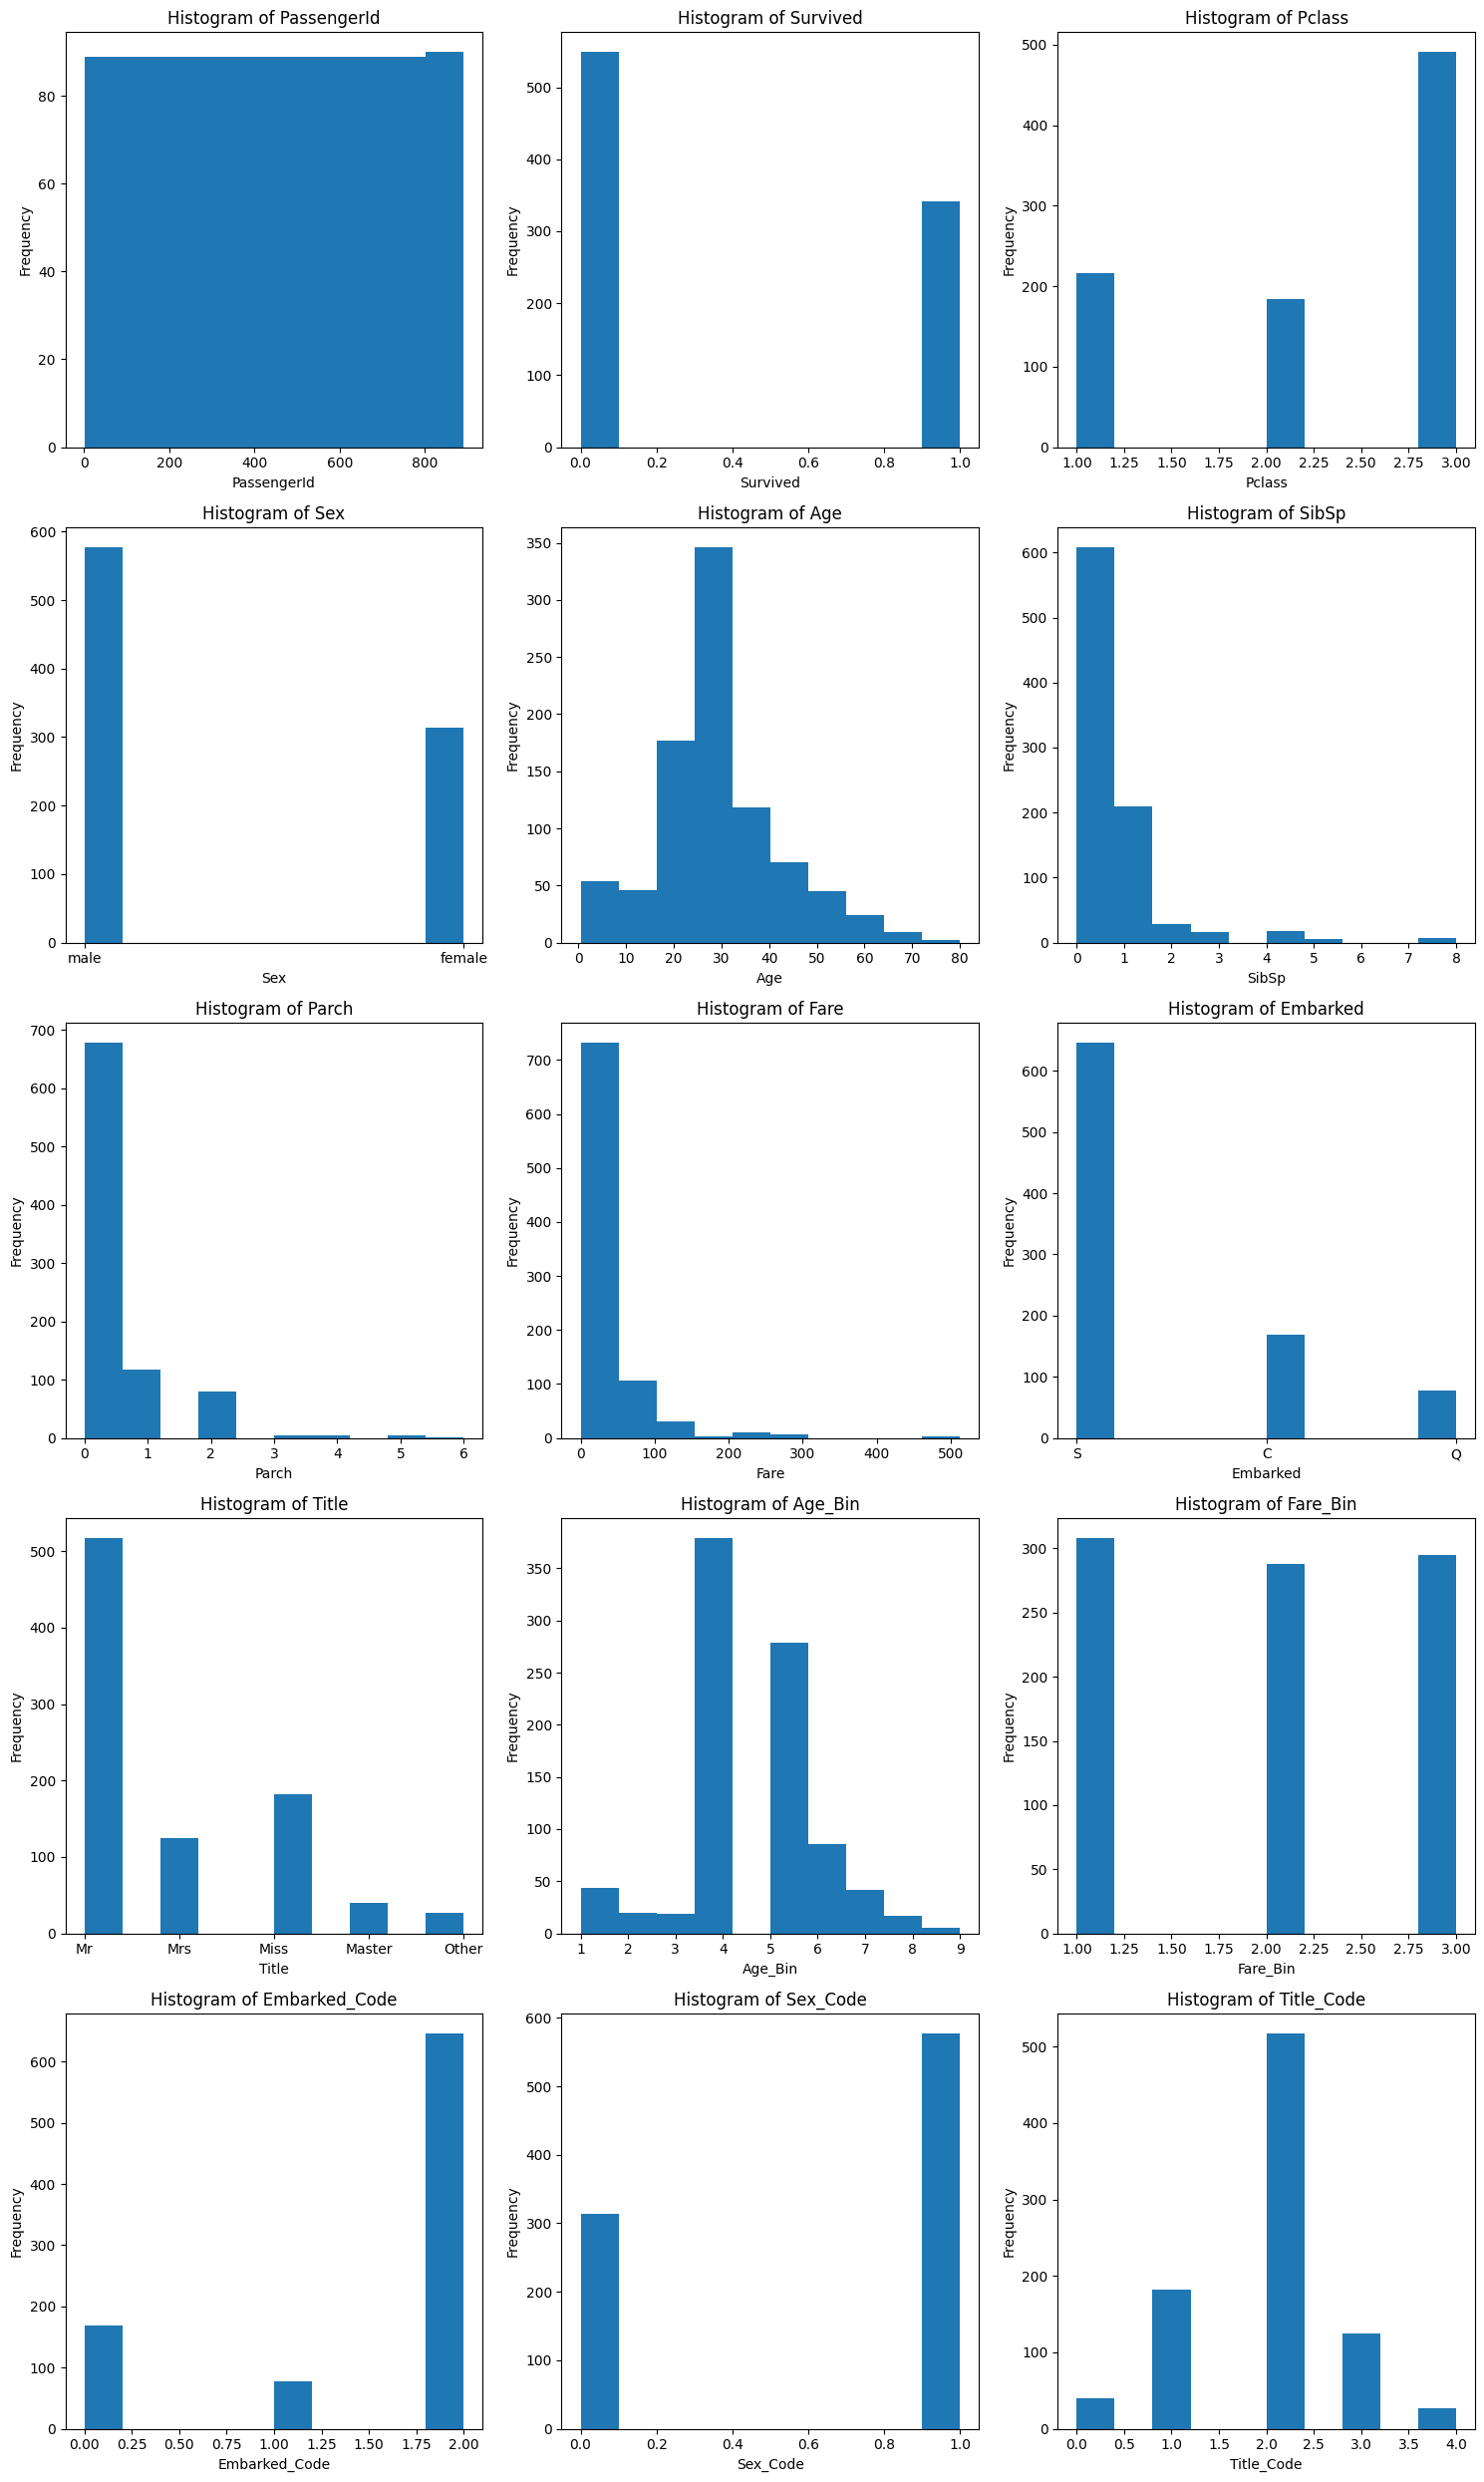

In [4127]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

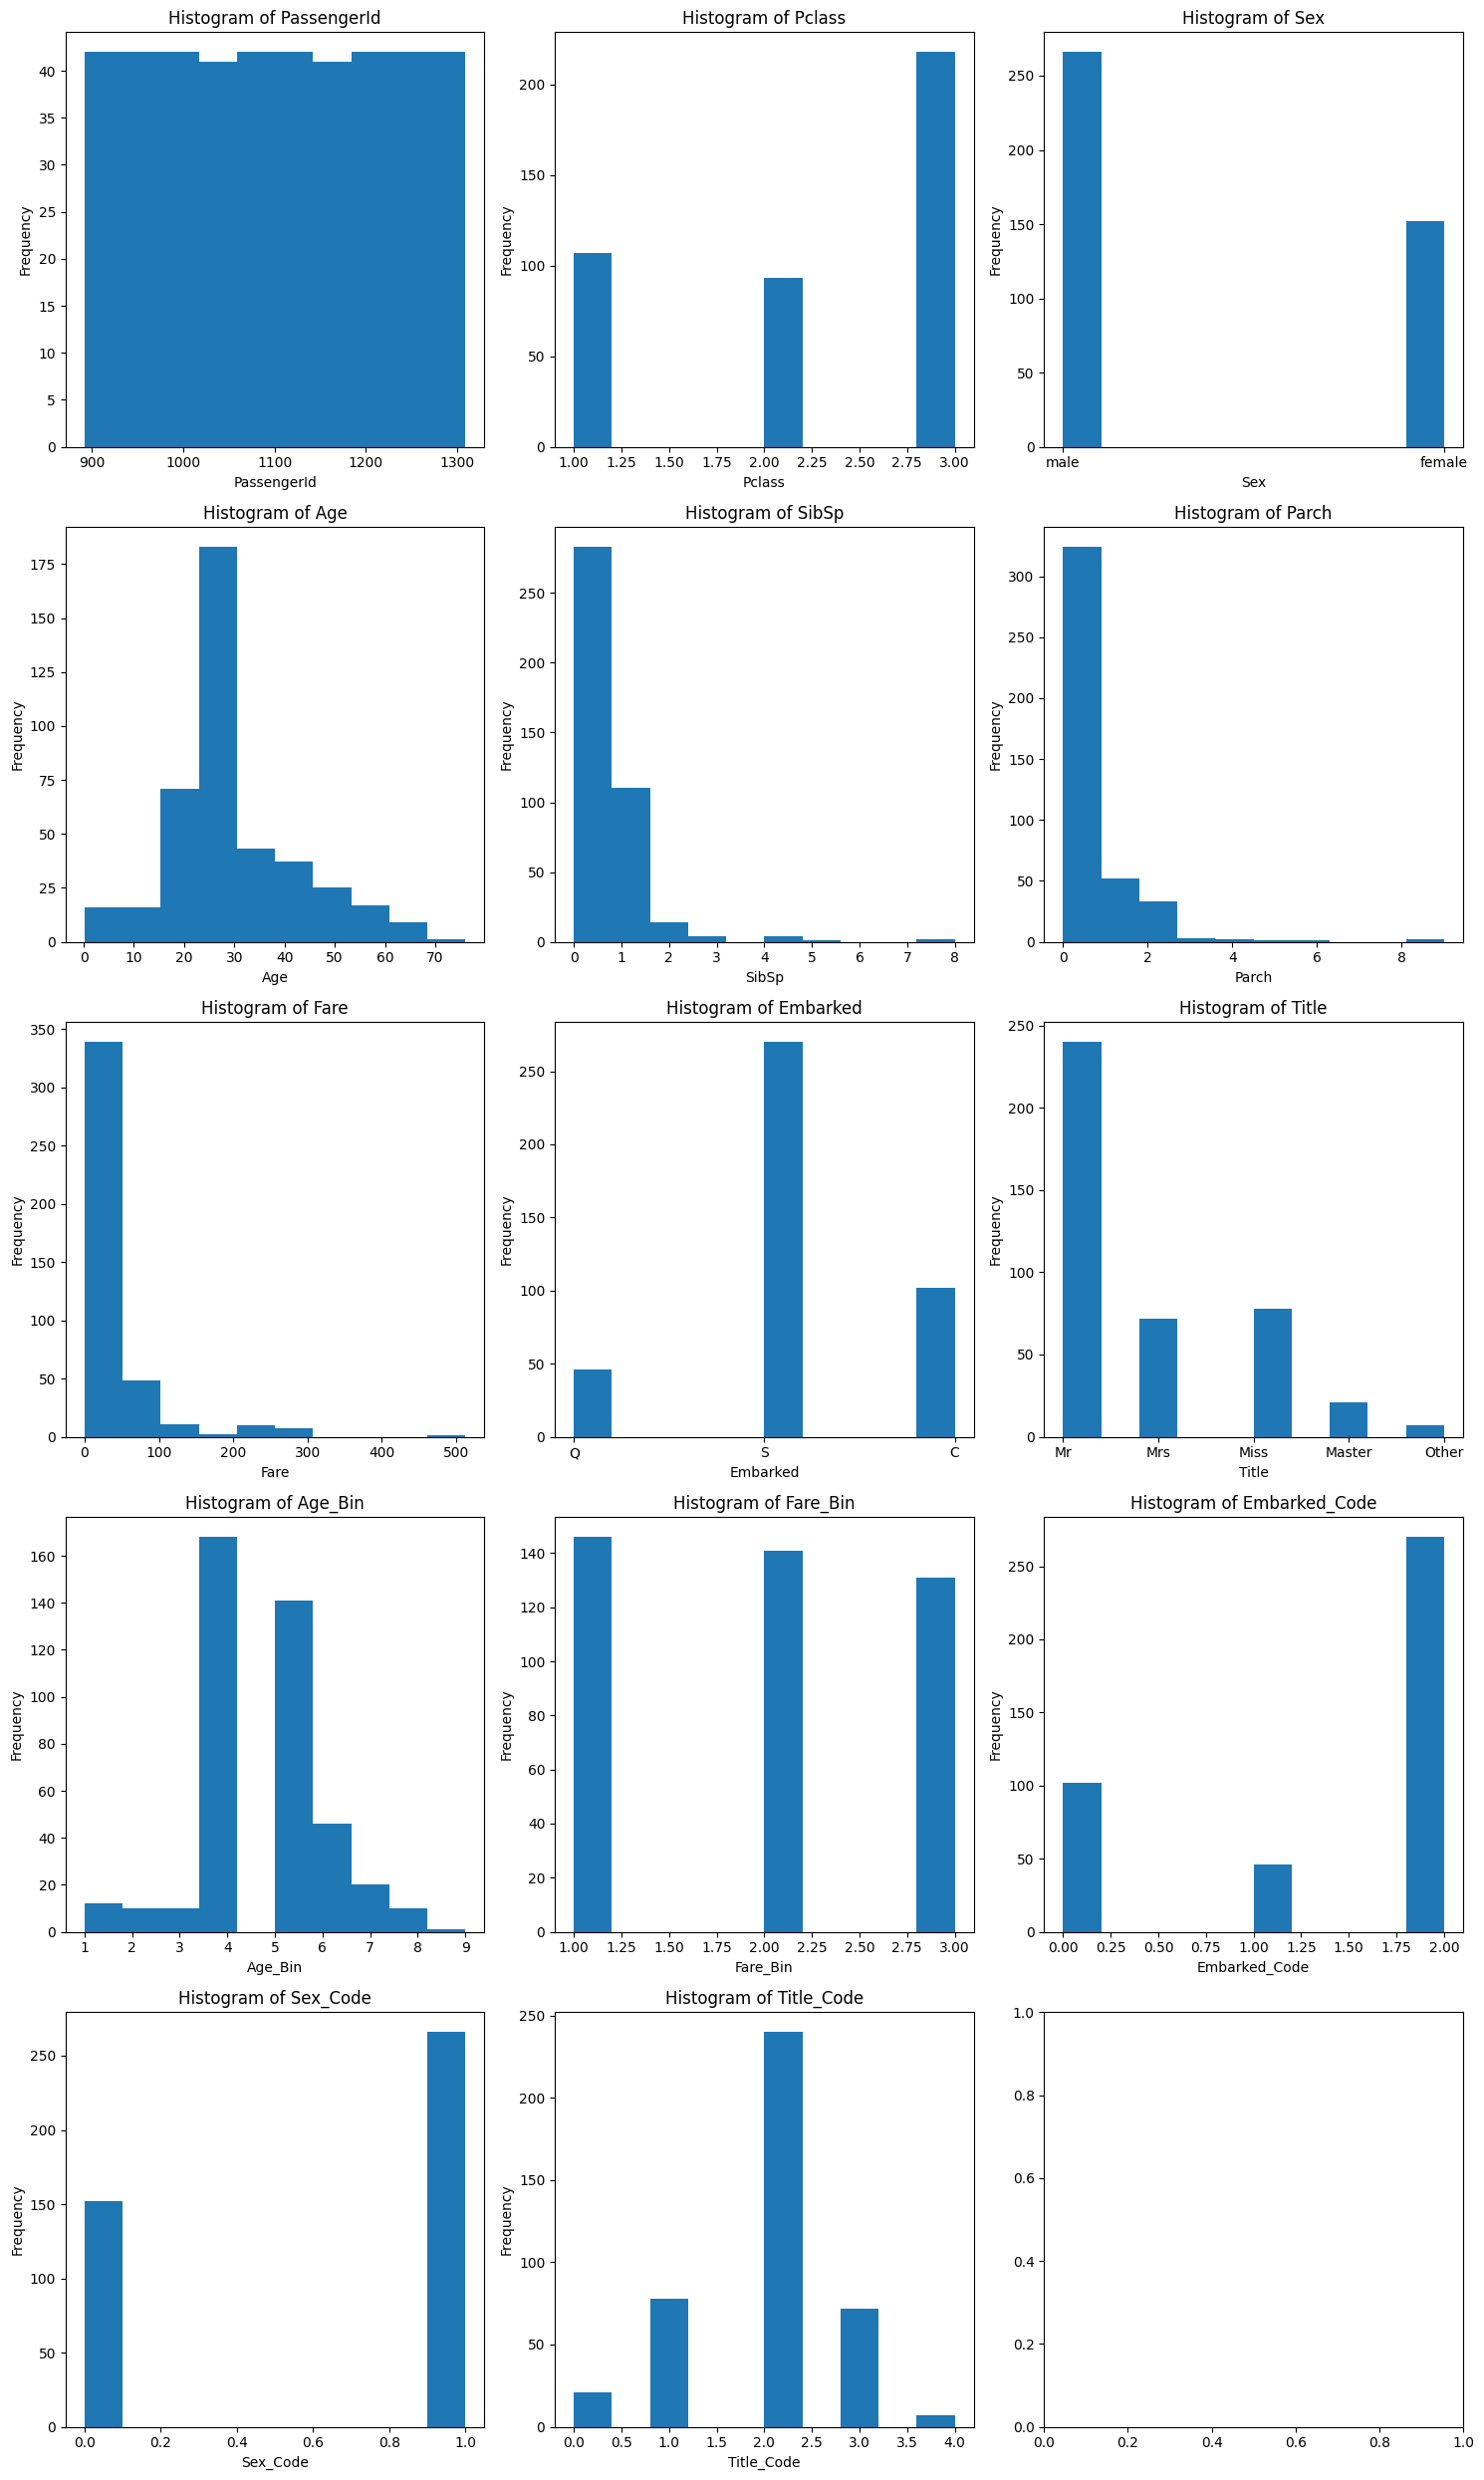

In [4128]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df_test.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df_test[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

Now let's see how the information breaks down in terms of survival rates.

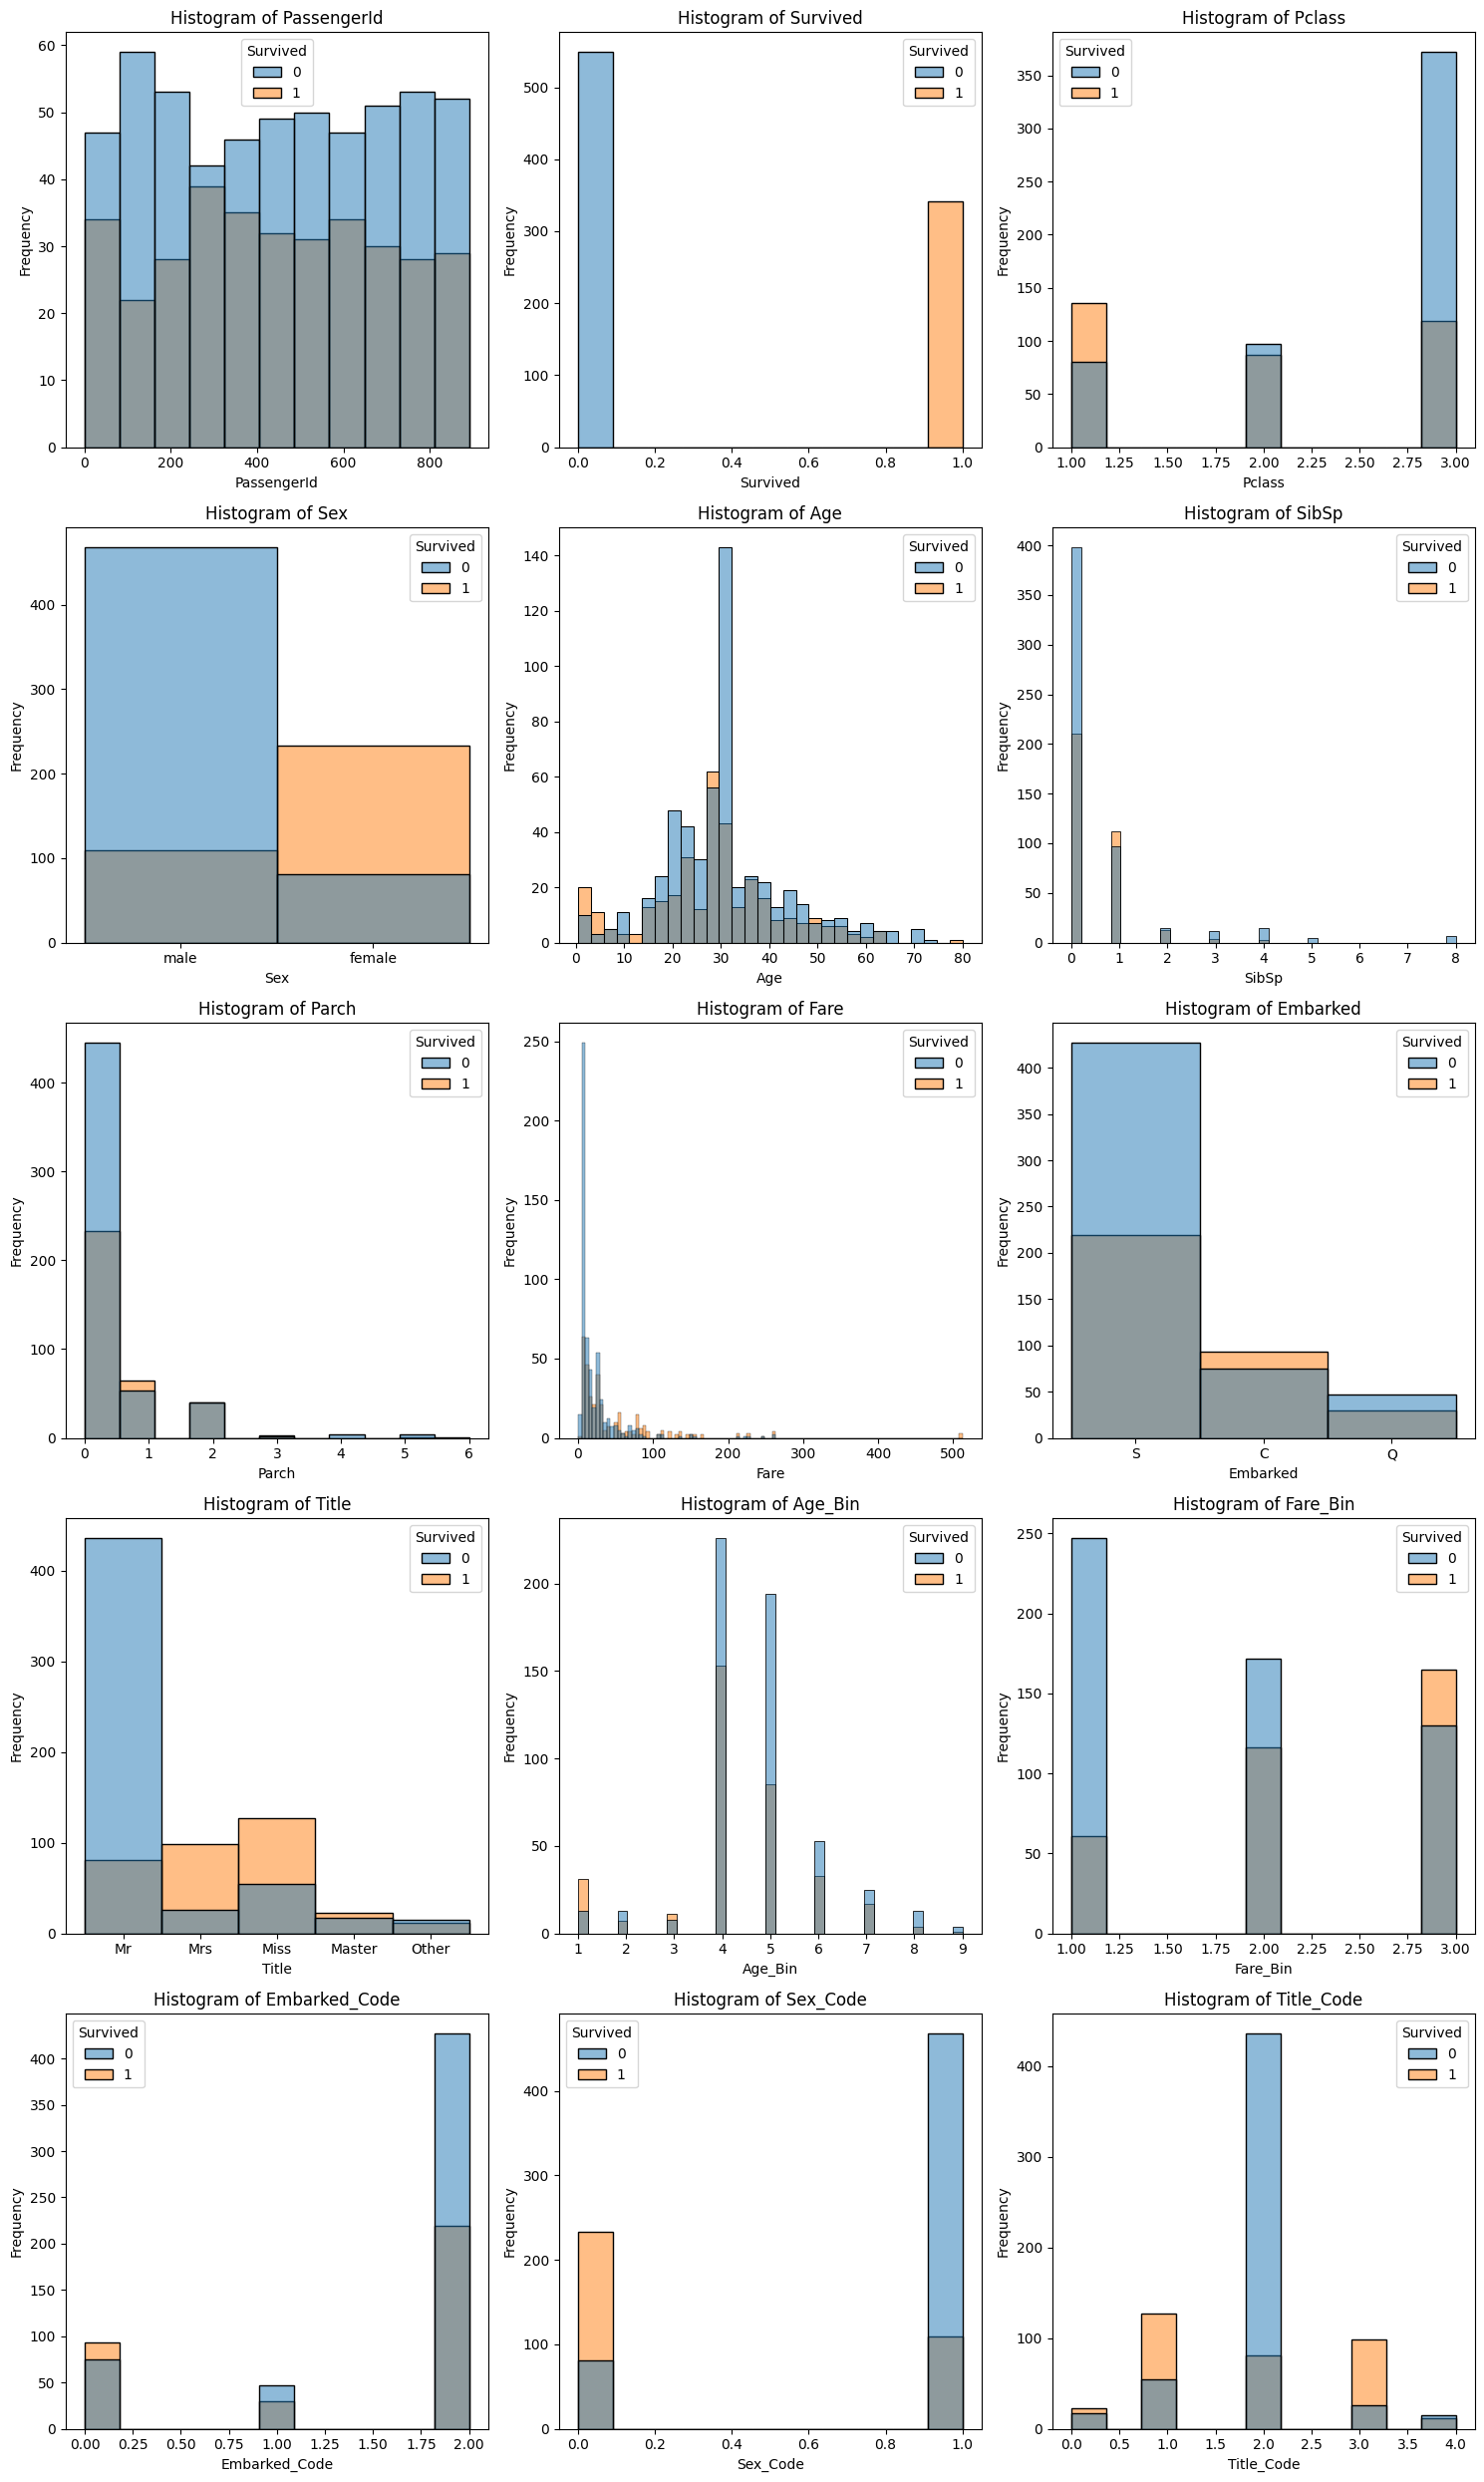

In [4129]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data=df, x=column, hue='Survived', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

Since age seems to be a major defining factor in survival rates, I want to make additional binary columns to distinguish if a passenger was a child or an elder. 

In [4130]:
df['Child'] = ((df['Age'] < 16)).astype(int)
df['Elder'] = ((df['Age'] > 60)).astype(int)
df['Age*Class*Sex'] = df['Age'] * df['Pclass'] * (df['Sex_Code'] +1)

df_test['Child'] = ((df_test['Age'] < 16)).astype(int)
df_test['Elder'] = ((df_test['Age'] > 60)).astype(int)
df_test['Age*Class*Sex'] = df_test['Age'] * df_test['Pclass'] * (df_test['Sex_Code'] +1)

In [4131]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code,Child,Elder,Age*Class*Sex
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,4,1,2,1,2,0,0,132.0
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,5,3,0,0,3,0,0,38.0
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,4,1,2,0,1,0,0,78.0
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,5,3,2,0,3,0,0,35.0
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,5,1,2,1,2,0,0,210.0


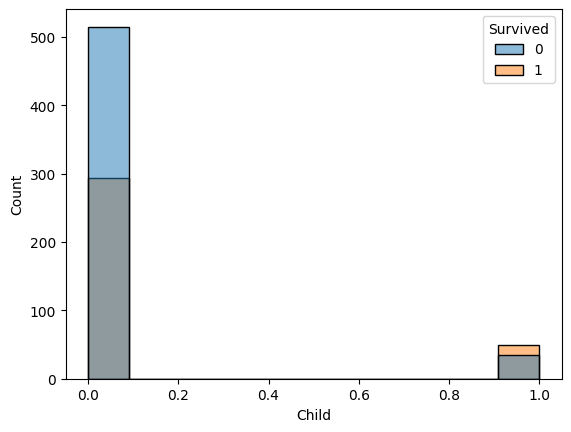

In [4132]:
sns.histplot(data=df, x='Child', hue='Survived')
plt.show()

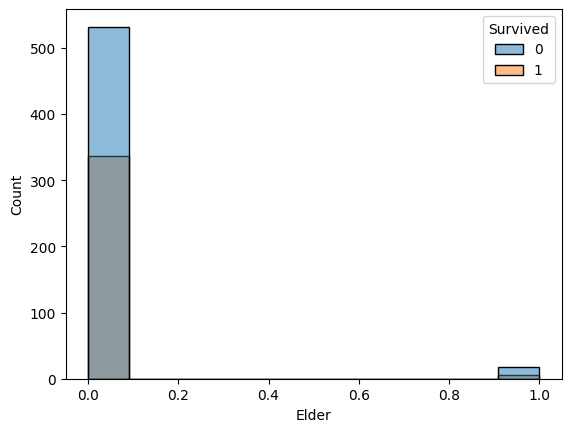

In [4133]:
sns.histplot(data=df, x='Elder', hue='Survived')
plt.show()

We can see that survival rate appears to be much lower for those labeled as Elder's and much higher for those labeled as children. Let's use some pie charts to do some more survival rate comparisons.

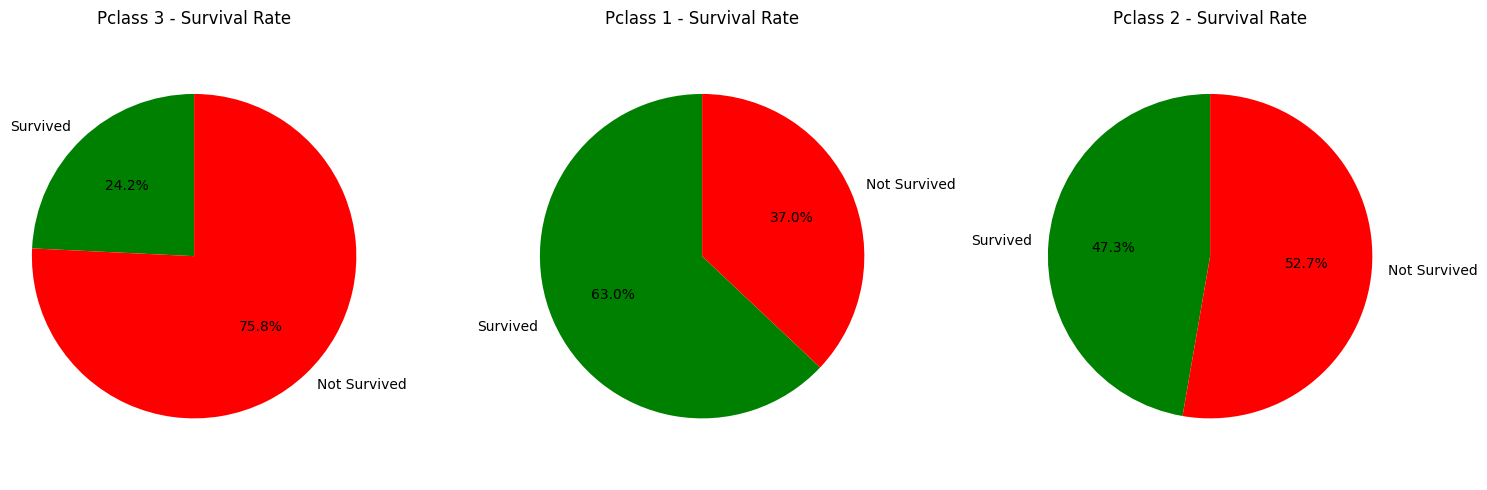

In [4134]:
survived_percentage = df.groupby('Pclass')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Pclass'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

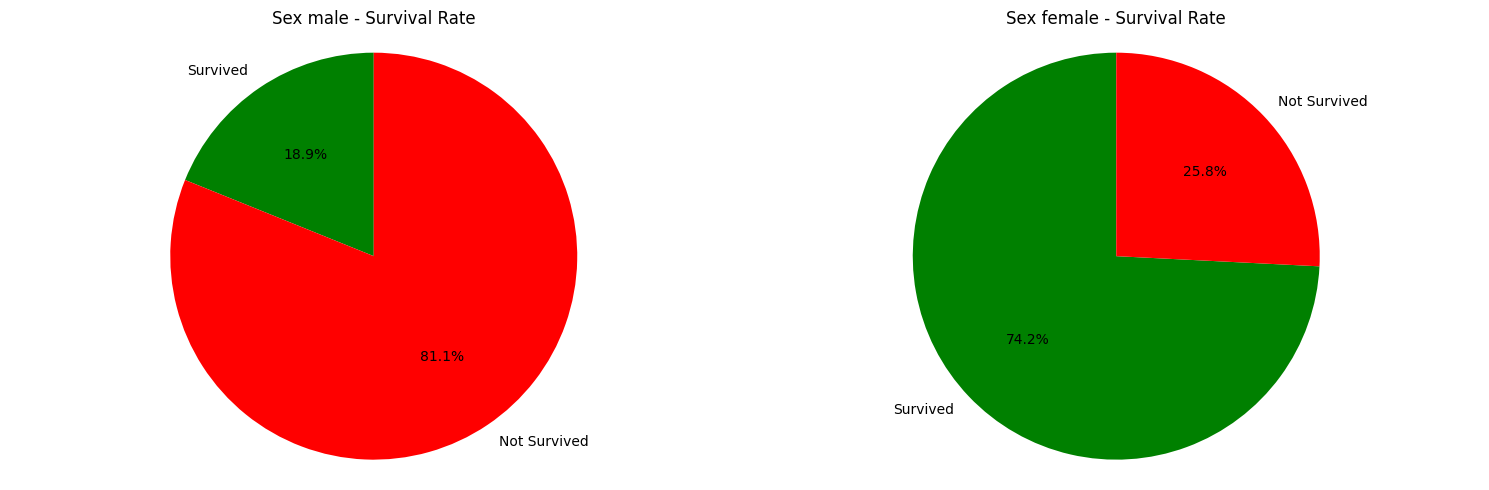

In [4135]:
survived_percentage = df.groupby('Sex')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each Pclass
for i, pclass in enumerate(df['Sex'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Sex {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

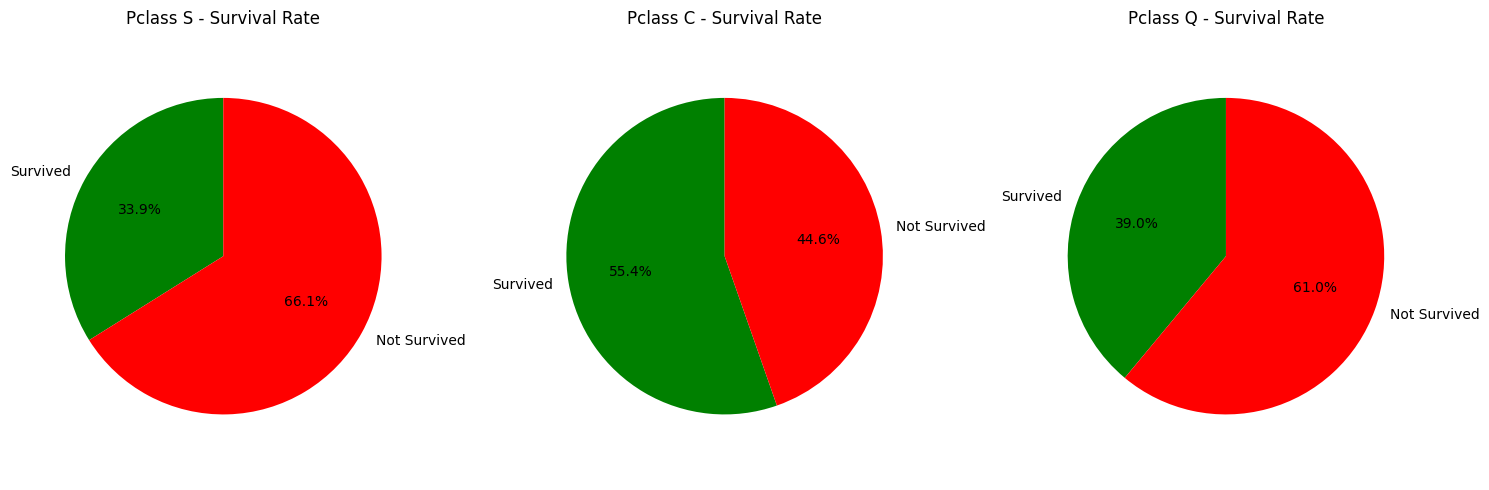

In [4136]:
survived_percentage = df.groupby('Embarked')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Embarked'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

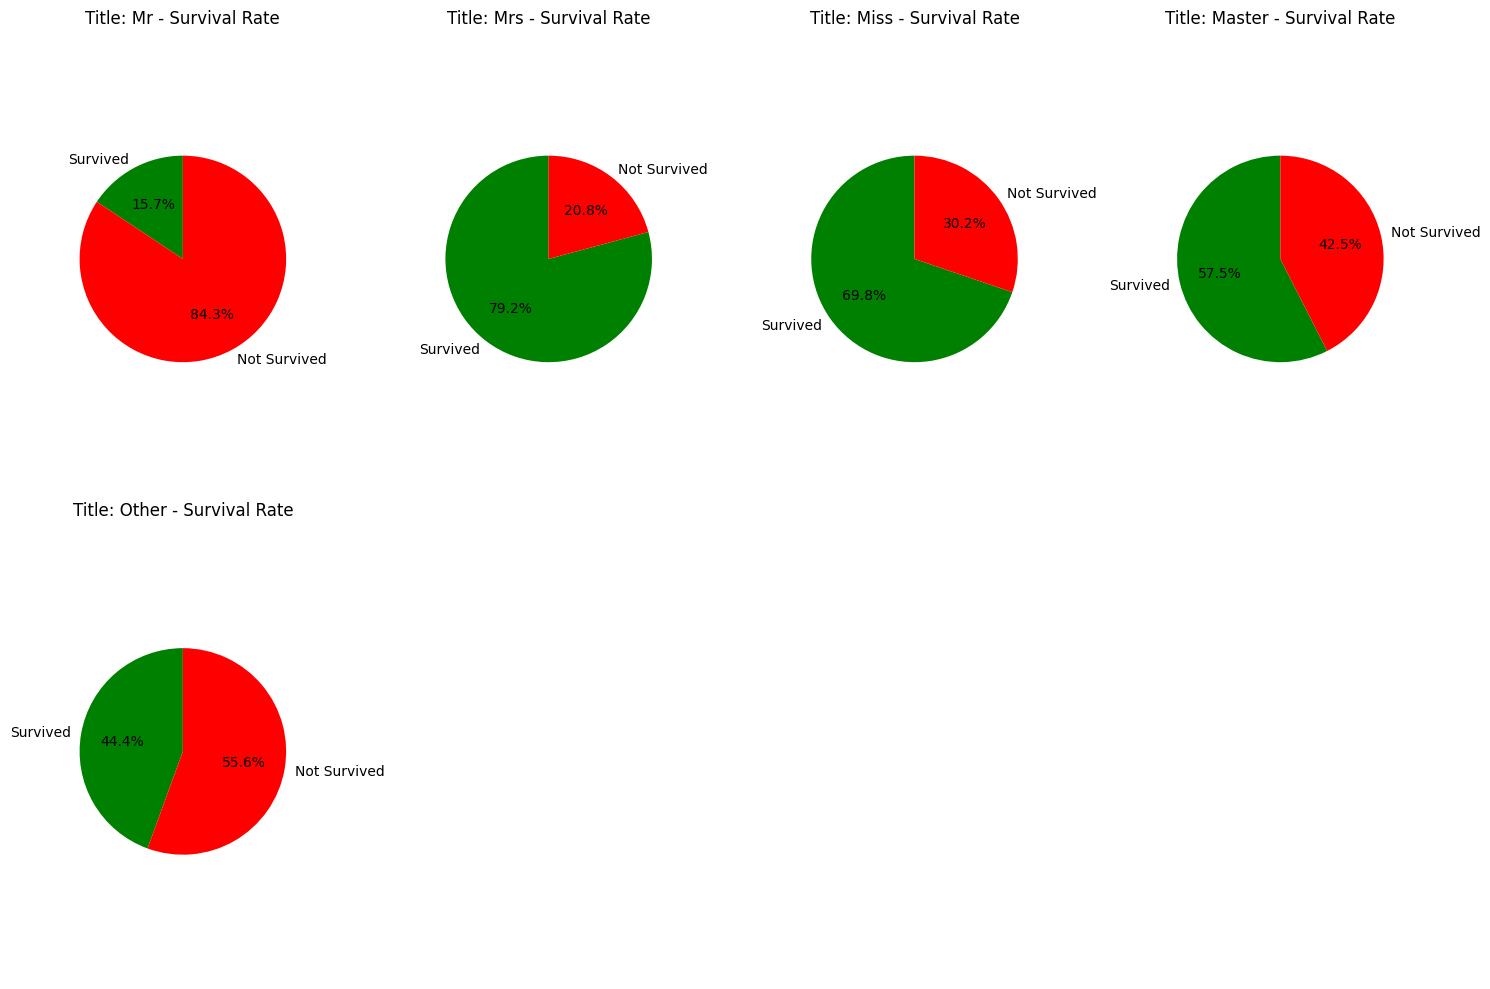

In [4137]:
survived_percentage = df.groupby('Title')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i, title in enumerate(df['Title'].unique()):
    row = i // 4
    col = i % 4
    
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[title], not_survived_percentage[title]]
    colors = ['green', 'red']
    
    ax = axes[row, col]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Title: {title} - Survival Rate')
    
# Remove empty subplots
if len(df['Title'].unique()) < 8:
    for i in range(len(df['Title'].unique()), 8):
        fig.delaxes(axes[1, i % 4])

plt.tight_layout()

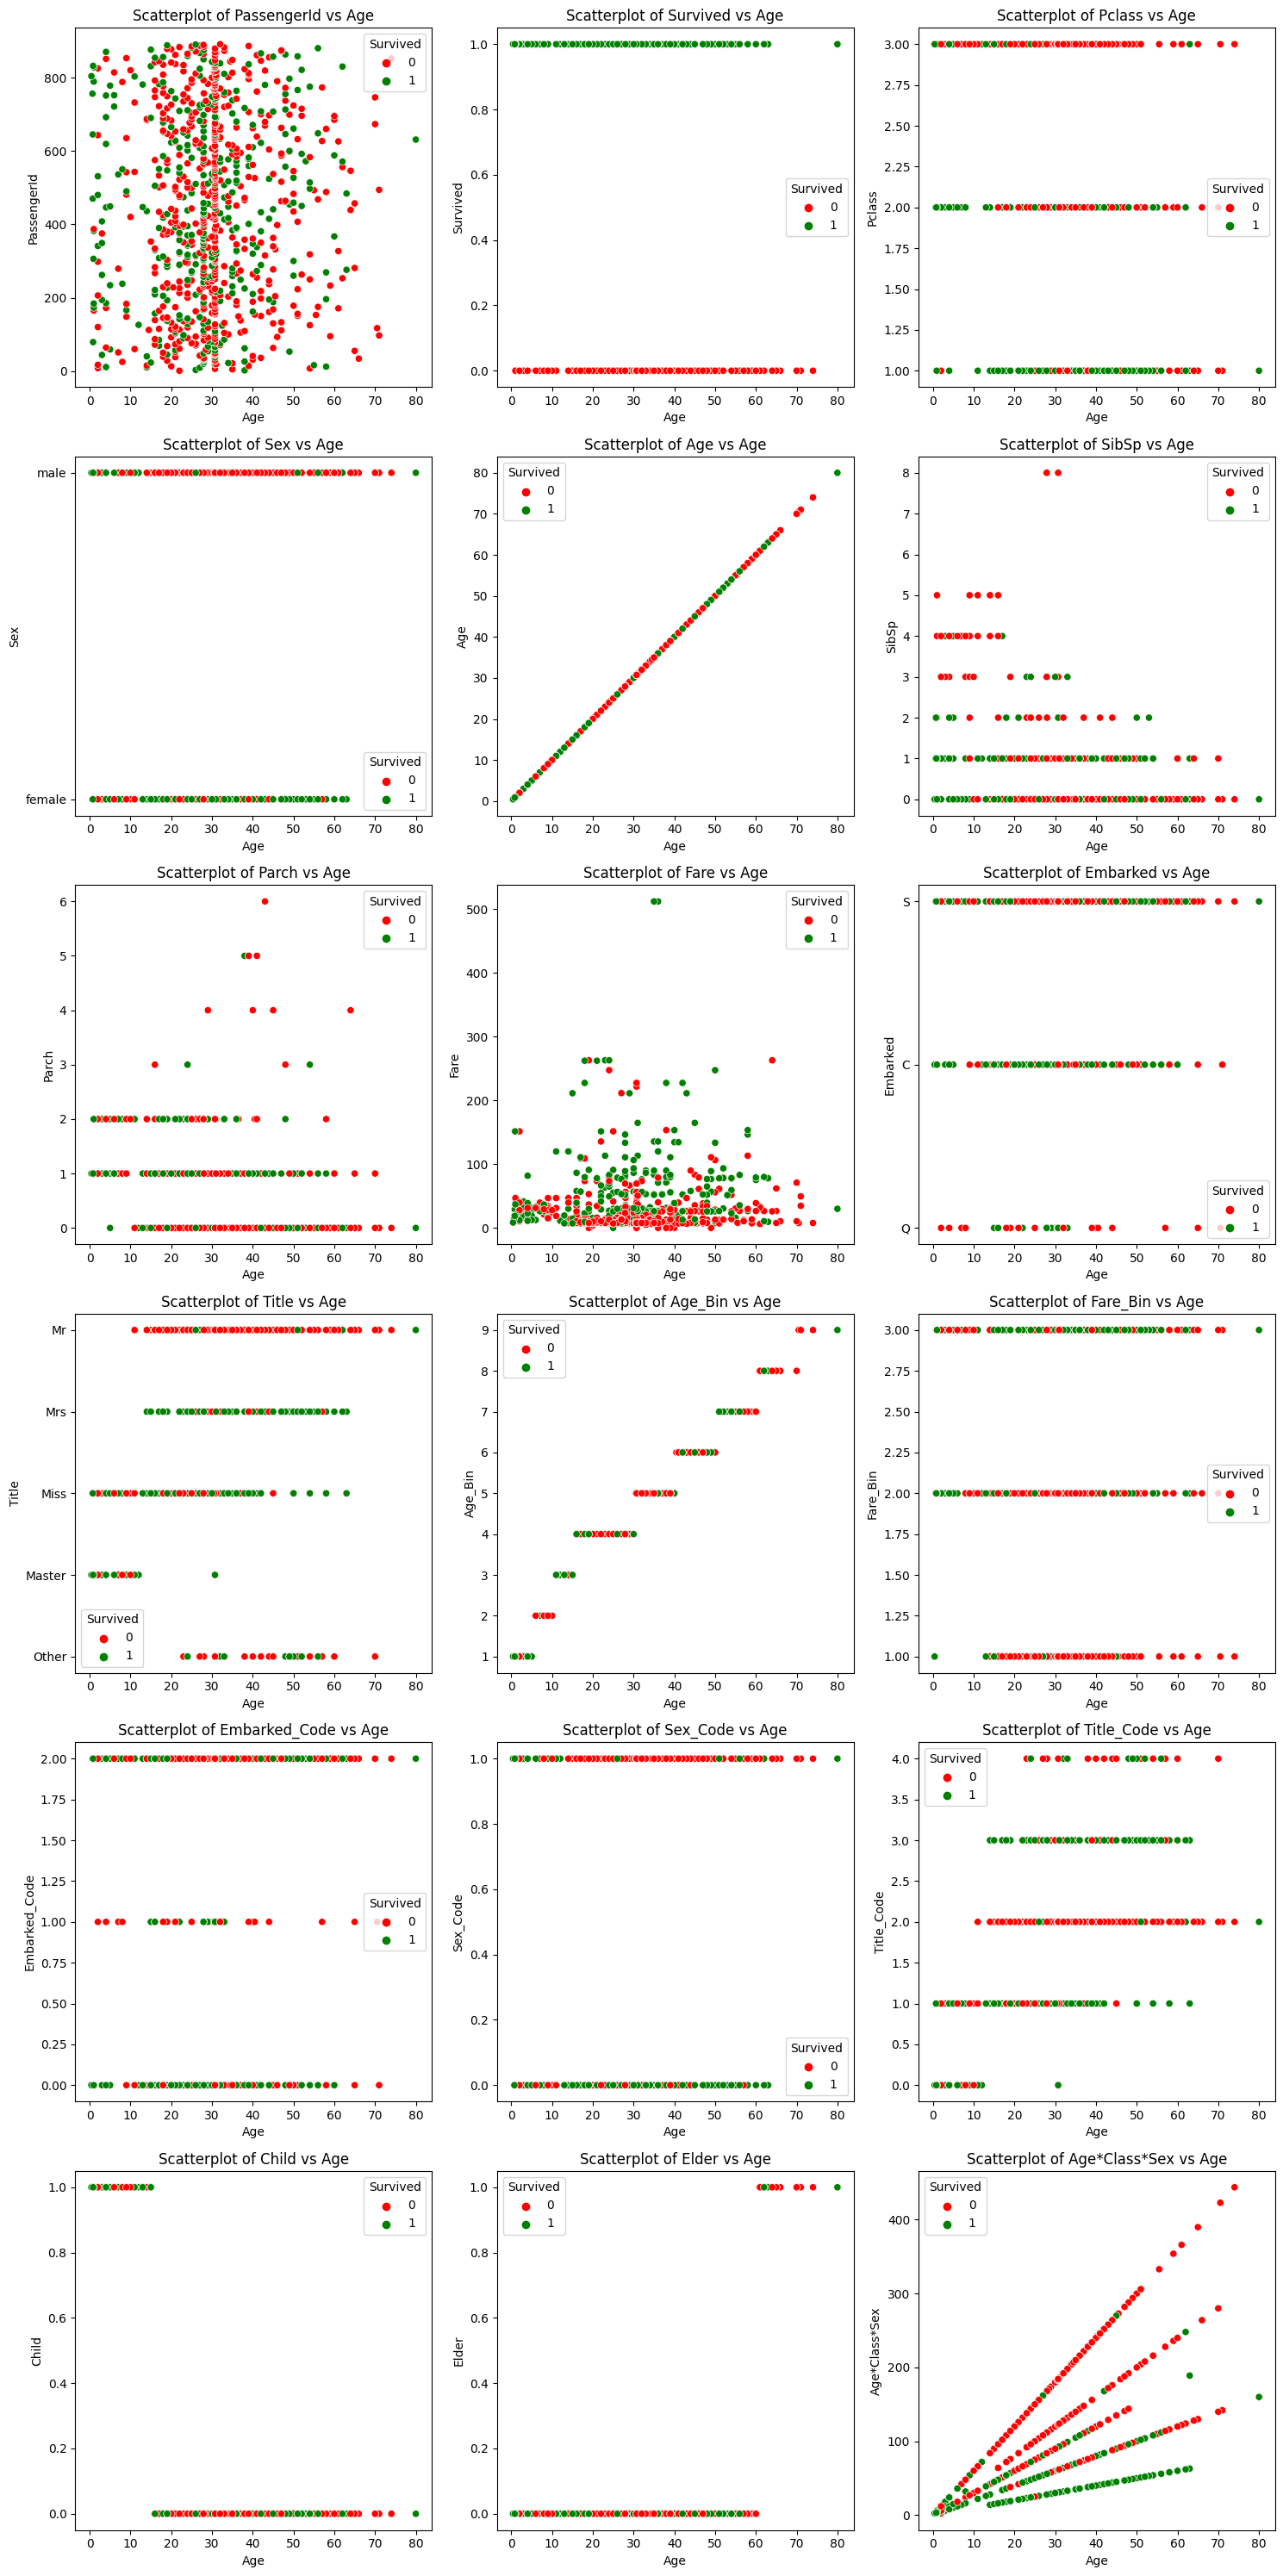

In [4138]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.scatterplot(data=df, x='Age', y=column, hue='Survived', palette=['red', 'green'], ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel(column)
    ax.set_title(f'Scatterplot of {column} vs Age')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

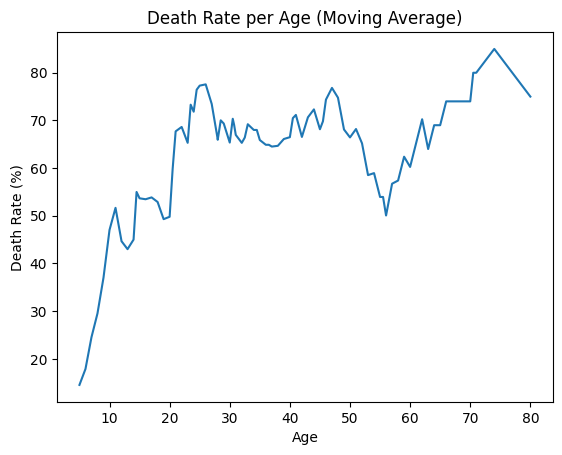

In [4139]:
death_rate_per_age = df.groupby(['Age'])['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)

moving_average = death_rate_per_age.rolling(window=10).mean()
plt.plot(death_rate_per_age.index, moving_average)
plt.xlabel('Age')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age (Moving Average)')
plt.show()

<Axes: xlabel='Pclass', ylabel='Survived'>

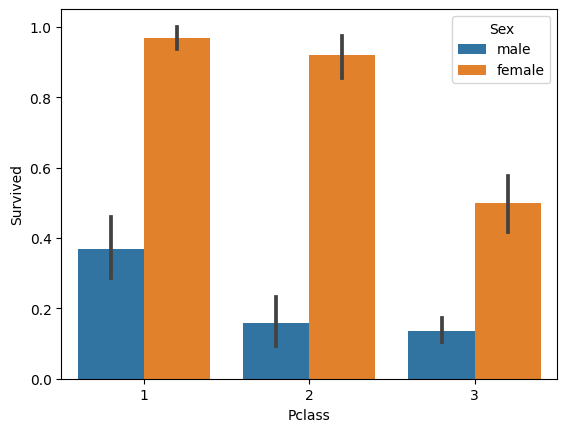

In [4140]:
sns.barplot(data=df, x='Pclass', y='Survived',hue='Sex')

<Axes: xlabel='Parch', ylabel='Survived'>

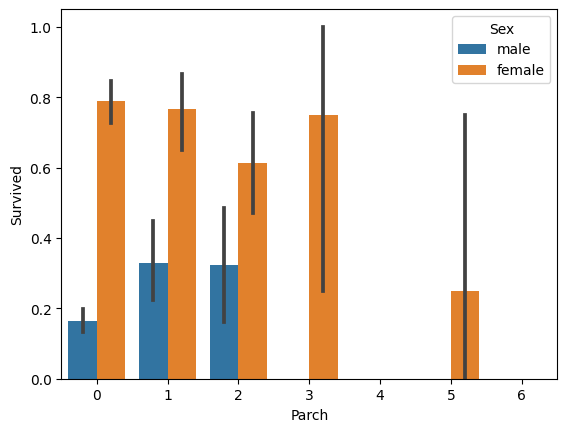

In [4141]:
sns.barplot(data=df, x='Parch', y='Survived',hue='Sex')

We can see that elements such as Sex, Class, Title, Age, and Parch all have impacts on survival rate. I want to explore if the size of someones guest list can be exploited further to find more insights. I'll make a column called Family size, and then corresponding Alone & Big Family binary columns to see if that provides more information.

In [4142]:
df['Fam_Size'] = df['SibSp'] + df['Parch'] + 1
df_test['Fam_Size'] = df_test['SibSp'] + df_test['Parch'] + 1

In [4143]:
df['Alone'] = ((df['Fam_Size'] == 1)).astype(int)
df['Family_Category'] = pd.cut(df['Fam_Size'], bins=[0, 1, 4, 6, float('inf')], labels=['Alone', 'Small', 'Medium', 'Large'])


In [4144]:
df_test['Alone'] = ((df_test['Fam_Size'] == 1)).astype(int)
df_test['Family_Category'] = pd.cut(df['Fam_Size'], bins=[0, 1, 4, 6, float('inf')], labels=['Alone', 'Small', 'Medium', 'Large'])

In [4145]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Title', 'Age_Bin', 'Fare_Bin', 'Embarked_Code',
       'Sex_Code', 'Title_Code', 'Child', 'Elder', 'Age*Class*Sex', 'Fam_Size',
       'Alone', 'Family_Category'],
      dtype='object')

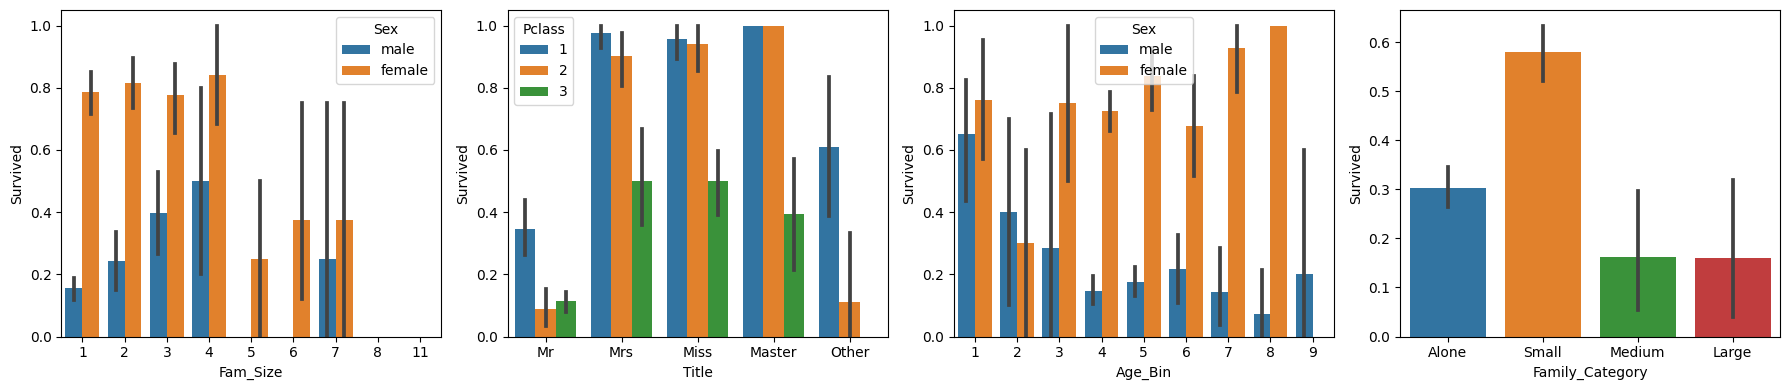

In [4146]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

sns.barplot(data=df, x='Fam_Size', y='Survived', hue='Sex', ax=axes[0])
sns.barplot(data=df, x='Title', y='Survived', hue='Pclass', ax=axes[1])
sns.barplot(data=df, x='Age_Bin', y='Survived', hue='Sex', ax=axes[2])
sns.barplot(data=df, x='Family_Category', y='Survived', ax=axes[3])



plt.tight_layout()


So we now have a good idea of the variations in survival rate based on various passenger attributes. What I want to do now is quantify that survival change as some sort of score. I'll make a new dataframe that is based on the survival rate of various columns to see if I can give people a score based on how many high risk/medium risk or low risk attributes they have.

In [4147]:
average_survival_rate_per_pclass = df.groupby('Pclass')['Survived'].mean()
average_survival_rate_per_sex = df.groupby('Sex')['Survived'].mean()
average_survival_rate_per_title = df.groupby('Title')['Survived'].mean()
average_survival_rate_per_age_bin = df.groupby('Age_Bin')['Survived'].mean()
average_survival_rate_per_fare_bin = df.groupby('Fare_Bin')['Survived'].mean()
average_survival_rate_per_embarked = df.groupby('Embarked')['Survived'].mean()

In [4148]:
df_survival_rate = df.copy()

In [4149]:
df_survival_rate['Survival_Rate_Pclass'] = df_survival_rate['Pclass'].map(average_survival_rate_per_pclass)
df_survival_rate['Survival_Rate_Sex'] = df_survival_rate['Sex'].map(average_survival_rate_per_sex)
df_survival_rate['Survival_Rate_Title'] = df_survival_rate['Title'].map(average_survival_rate_per_title)
df_survival_rate['Survival_Rate_Age_Bin'] = df_survival_rate['Age_Bin'].map(average_survival_rate_per_age_bin)
df_survival_rate['Survival_Rate_Fare_Bin'] = df_survival_rate['Fare_Bin'].map(average_survival_rate_per_fare_bin)
df_survival_rate['Survival_Rate_Embarked'] = df_survival_rate['Embarked'].map(average_survival_rate_per_embarked)

df_survival_rate['Survival_Level_Pclass'] = pd.cut(df_survival_rate['Survival_Rate_Pclass'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Sex'] = pd.cut(df_survival_rate['Survival_Rate_Sex'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Title'] = pd.cut(df_survival_rate['Survival_Rate_Title'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Age_Bin'] = pd.cut(df_survival_rate['Survival_Rate_Age_Bin'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Fare_Bin'] = pd.cut(df_survival_rate['Survival_Rate_Fare_Bin'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Embarked'] = pd.cut(df_survival_rate['Survival_Rate_Embarked'], bins=4, labels=[1, 2, 3, 4]).astype(int)

df_survival_rate['Survival_Level_Sum'] = df_survival_rate[['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked']].sum(axis=1)

In [4150]:
df_survival_rate.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,...,Survival_Rate_Age_Bin,Survival_Rate_Fare_Bin,Survival_Rate_Embarked,Survival_Level_Pclass,Survival_Level_Sex,Survival_Level_Title,Survival_Level_Age_Bin,Survival_Level_Fare_Bin,Survival_Level_Embarked,Survival_Level_Sum
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,...,0.403694,0.198052,0.339009,1,1,1,2,1,1,7
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,...,0.304659,0.559322,0.553571,4,4,4,1,4,4,21
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,...,0.403694,0.198052,0.339009,1,4,4,2,1,1,13
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,...,0.304659,0.559322,0.339009,4,4,4,1,4,1,18
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,...,0.304659,0.198052,0.339009,1,1,1,1,1,1,6


Great, so we now have 4 survival levels for some key columns (1 for low survival rate, 4 for high). Let's use this info to decide how to add some survival scores to our main dataframe.

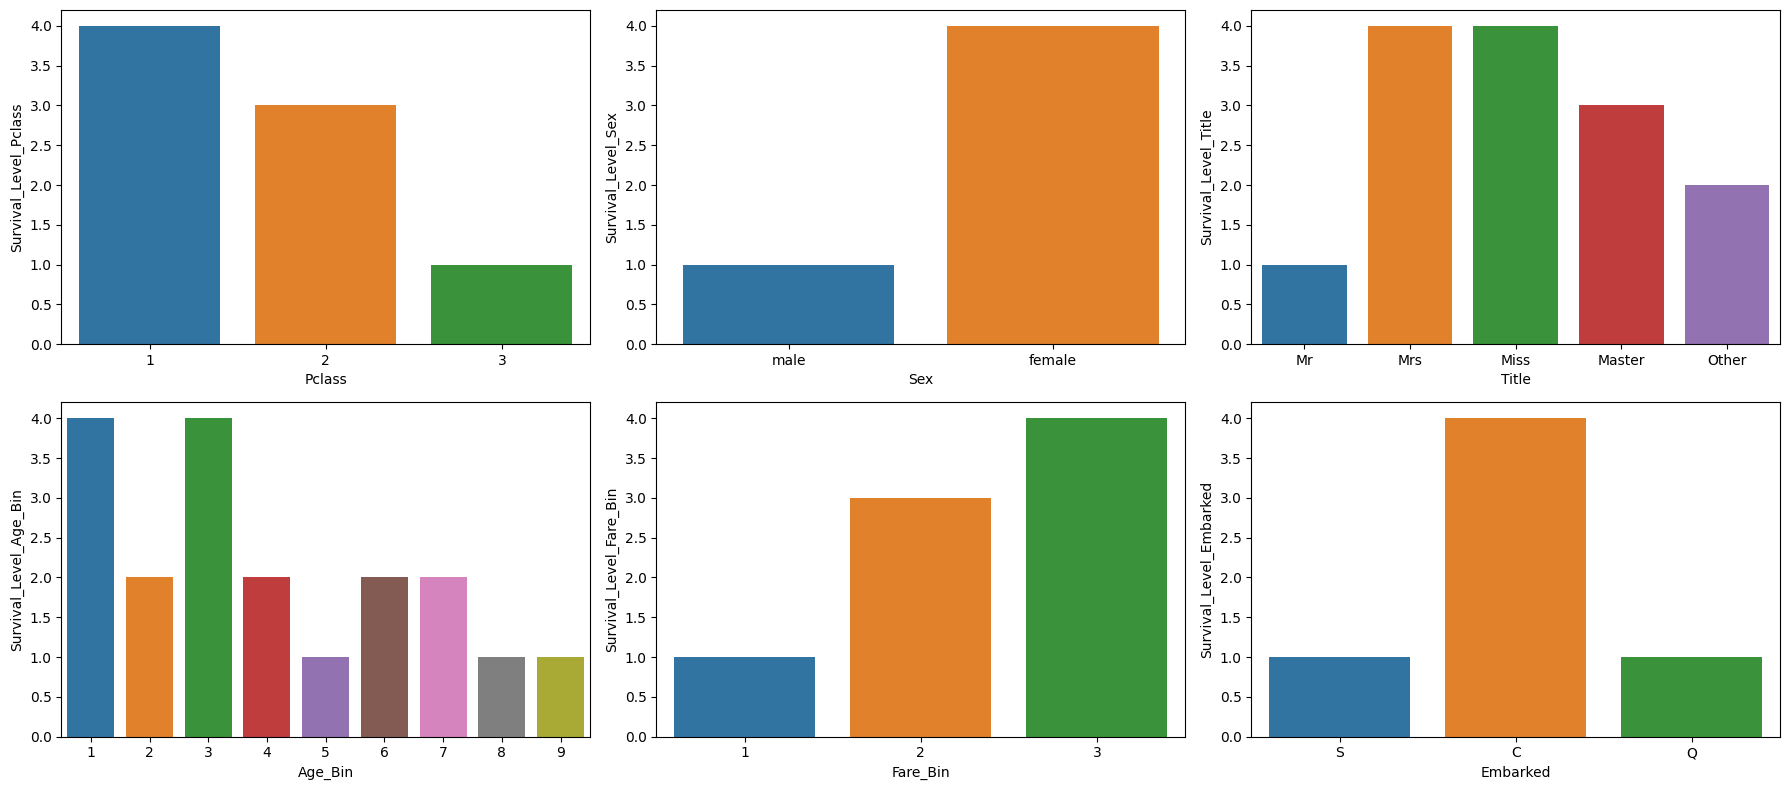

In [4151]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

sns.barplot(data=df_survival_rate, x='Pclass', y='Survival_Level_Pclass', ax=axes[0, 0])
sns.barplot(data=df_survival_rate, x='Sex', y='Survival_Level_Sex', ax=axes[0, 1])
sns.barplot(data=df_survival_rate, x='Title', y='Survival_Level_Title', ax=axes[0, 2])


sns.barplot(data=df_survival_rate, x='Age_Bin', y='Survival_Level_Age_Bin', ax=axes[1, 0])
sns.barplot(data=df_survival_rate, x='Fare_Bin', y='Survival_Level_Fare_Bin', ax=axes[1, 1])
sns.barplot(data=df_survival_rate, x='Embarked', y='Survival_Level_Embarked', ax=axes[1, 2])

plt.tight_layout()



Based on these visuals, I can apply a score to different values in those columns. For instance, someone in first class can have a 3 survival score since they are most likely to survive amongst that variable. I'll aim for 3 levels per variable, however for extreme discrepencies, I may keep all 4 survival levels for certain columns.

Mapping the column values to their respective survival level.

In [4152]:
def add_survival_levels(df):
    df['Survival_Level_Pclass'] = df['Pclass'].map({1: 3, 2: 2, 3: 1}).astype(int)
    df['Survival_Level_Sex'] = df['Sex'].map({'male': 1, 'female': 3}).astype(int)
    df['Survival_Level_Title'] = df['Title'].map({'Mr': 1, 'Mrs': 4, 'Miss': 4, 'Master': 3, 'Other': 2}).astype(int)
    df['Survival_Level_Age_Bin'] = df['Age_Bin'].map({1: 4, 2: 2, 3: 4, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 9: 1}).astype(int)
    df['Survival_Level_Fare_Bin'] = df['Fare_Bin'].map({1: 1, 2: 2, 3: 3}).astype(int)
    df['Survival_Level_Embarked'] = df['Embarked'].map({'S': 1, 'C': 3, 'Q': 1}).astype(int)
    df['Survival_Level_Family'] = df['Family_Category'].map({'Medium': 3, 'Large': 3, 'Alone': 2, 'Small': 1}).astype(int)

    df['Survival_Level_Sum'] = df[['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family']].sum(axis=1)
    return df


In [4153]:
df = add_survival_levels(df)
df_test = add_survival_levels(df_test)

In [4154]:
df.drop(['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family'], axis=1, inplace=True)
df_test.drop(['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family'], axis=1, inplace=True)


In [4155]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,...,Embarked_Code,Sex_Code,Title_Code,Child,Elder,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Level_Sum
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,...,2,1,2,0,0,132.0,2,0,Small,8
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,...,0,0,3,0,0,38.0,2,0,Small,18
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,...,2,0,1,0,0,78.0,1,1,Alone,14
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,...,2,0,3,0,0,35.0,2,0,Small,16
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,...,2,1,2,0,0,210.0,1,1,Alone,8


In [4156]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,...,Embarked_Code,Sex_Code,Title_Code,Child,Elder,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Level_Sum
0,892,3,male,34.5,0,0,7.8292,Q,Mr,5,...,1,1,2,0,0,207.0,1,1,Small,7
1,893,3,female,47.0,1,0,7.0000,S,Mrs,6,...,2,0,3,0,0,141.0,2,0,Small,13
2,894,2,male,62.0,0,0,9.6875,Q,Mr,8,...,1,1,2,0,1,248.0,1,1,Alone,10
3,895,3,male,27.0,0,0,8.6625,S,Mr,4,...,2,1,2,0,0,162.0,1,1,Small,8
4,896,3,female,22.0,1,1,12.2875,S,Mrs,4,...,2,0,3,0,0,66.0,3,0,Alone,15


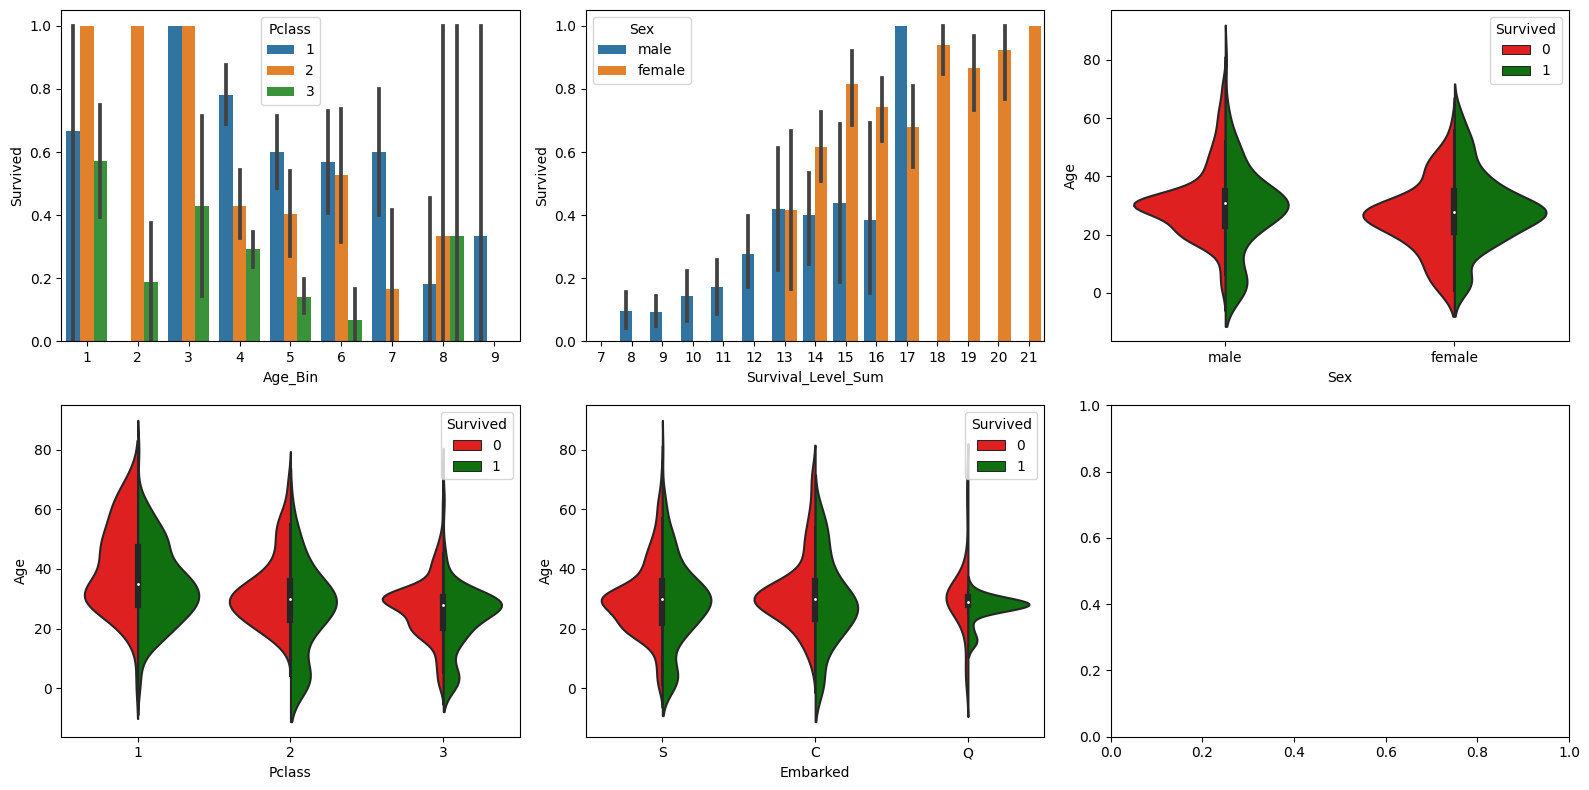

In [4157]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

sns.barplot(data=df, x='Age_Bin', y='Survived', hue='Pclass', ax=axes[0, 0])
sns.barplot(data=df, x='Survival_Level_Sum', y='Survived', hue='Sex', ax=axes[0, 1])
sns.violinplot(data=df, x='Sex', y='Age', hue='Survived', split=True, palette=['red', 'green'], ax=axes[0, 2])
sns.violinplot(data=df, x='Pclass', y='Age', hue='Survived', split=True, palette=['red', 'green'], ax=axes[1, 0])
sns.violinplot(data=df, x='Embarked', y='Age', hue='Survived', split=True, palette=['red', 'green'], ax=axes[1, 1])

plt.tight_layout()


In [4158]:
survival_rate = df.groupby('Survival_Level_Sum')['Survived'].mean()
print(survival_rate)


Survival_Level_Sum
7     0.000000
8     0.096491
9     0.092857
10    0.144737
11    0.172840
12    0.275862
13    0.418605
14    0.533898
15    0.703704
16    0.683544
17    0.687500
18    0.939394
19    0.866667
20    0.923077
21    1.000000
Name: Survived, dtype: float64


In [4159]:
df['Survival_Chance'] = pd.cut(df['Survival_Level_Sum'], bins=[0, 11, 14, 17, float('inf')], labels=[1, 2, 3, 4]).astype(int)
df_test['Survival_Chance'] = pd.cut(df['Survival_Level_Sum'], bins=[0, 11, 14, 17, float('inf')], labels=[1, 2, 3, 4]).astype(int)



In [4160]:
survival_rate = df.groupby('Survival_Chance')['Survived'].mean()
print(survival_rate)

Survival_Chance
1    0.118644
2    0.442922
3    0.690608
4    0.910256
Name: Survived, dtype: float64


Now let's review what the correlation is between our variables and survival to start determining which columns to use in our models.

In [4161]:
df = df.drop(['PassengerId', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Survival_Level_Sum'], axis=1)
df_test = df_test.drop(['SibSp', 'Parch', 'Fare', 'Embarked', 'Title'], axis=1)

/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_27199/827375925.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


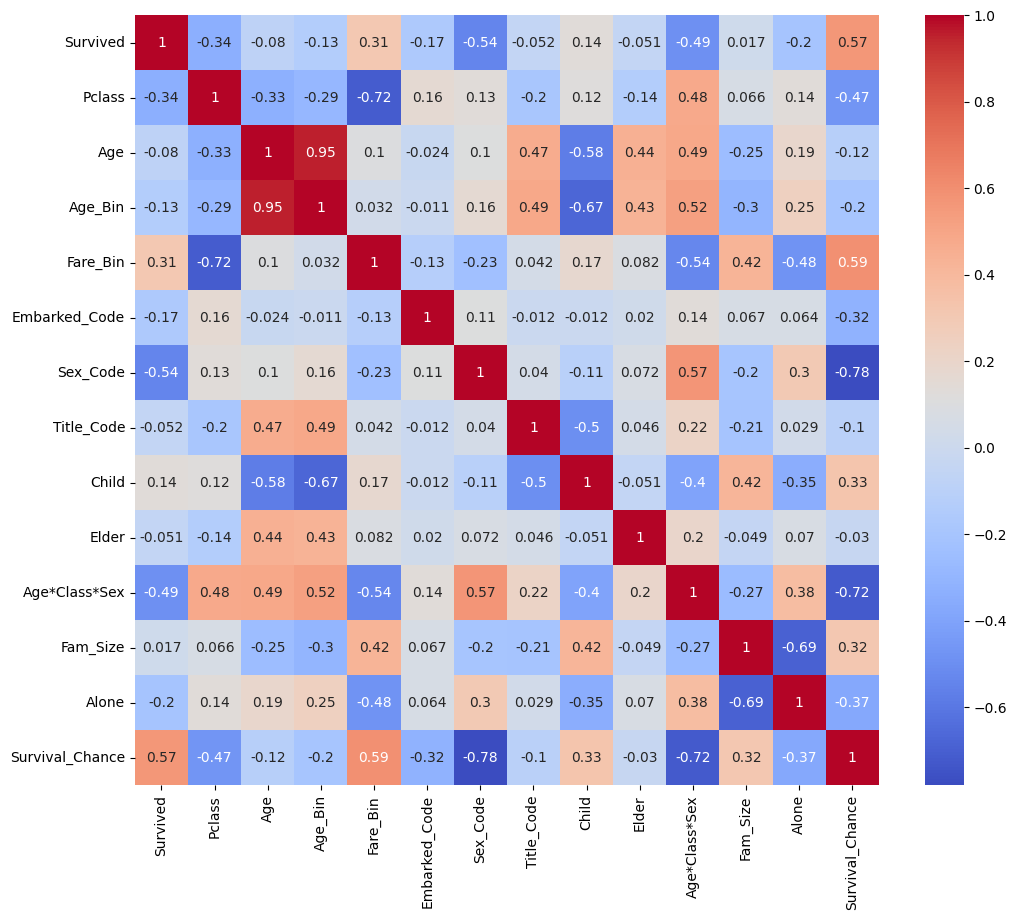

In [4162]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [4163]:
survived_correlation = correlation_matrix['Survived'].sort_values(ascending=False)
print(survived_correlation)

Survived           1.000000
Survival_Chance    0.567719
Fare_Bin           0.305799
Child              0.136107
Fam_Size           0.016639
Elder             -0.051224
Title_Code        -0.052471
Age               -0.080453
Age_Bin           -0.134327
Embarked_Code     -0.167675
Alone             -0.203367
Pclass            -0.338481
Age*Class*Sex     -0.490638
Sex_Code          -0.543351
Name: Survived, dtype: float64


In [4164]:
from sklearn.ensemble import RandomForestClassifier

# Separate the features and target variable
X = df.drop(['Survived', 'Sex', 'Family_Category', 'Age'], axis=1)
y = df['Survived']

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Fit the classifier to the data
rf.fit(X, y)

# Get the feature importances
feature_importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Print the feature importances in descending order
for index in sorted_indices:
    feature = X.columns[index]
    importance = feature_importances[index]
    print(f'{feature}: {importance}')
    


Age*Class*Sex: 0.3836319315683369
Sex_Code: 0.1498677100863127
Survival_Chance: 0.09551465092877556
Fam_Size: 0.08198723555049685
Pclass: 0.06664994386592962
Title_Code: 0.05228212796076502
Age_Bin: 0.05194178751240528
Fare_Bin: 0.05078372214503273
Embarked_Code: 0.036633531641117836
Alone: 0.018007937075297513
Child: 0.009751208323535685
Elder: 0.0029482133419941443


In [4165]:
cat_columns = ['Survival_Chance', 'Sex_Code', 'Pclass', 'Age_Bin', 'Title_Code', 'Family_Category', 'Fare_Bin', 'Embarked_Code']
num_columns = ['Age*Class*Sex']
target = 'Survived'

In [4166]:
X_train_temp, X_test_valid, y_train_temp, y_test_valid = train_test_split(df[cat_columns + num_columns], df[target], test_size=0.3, random_state=42)

# Second split: Split the 20% into testing and validation (50% each of 20% -> 10% each of total data)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [4167]:
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_columns), ('num', num_transformer, num_columns)])

In [4168]:
X_train_transformed = preprocessor.fit_transform(X_train_temp)
X_test_transformed = preprocessor.transform(X_test)
X_valid_transformed = preprocessor.transform(X_valid)

In [4169]:
param_grid = {'C': [0.1, 1, 10, 100], 'max_iter': [5000, 10000], 'dual': [False, True]}

grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_linear_model = grid_search.best_estimator_


linear_predict_test = best_linear_model.predict(X_test_transformed)
linear_predict_valid = best_linear_model.predict(X_valid_transformed)

linear_accuracy_score_test =  metrics.accuracy_score(y_test, linear_predict_test)
linear_f1_score_test = f1_score(y_test, linear_predict_test)
linear_auc_score_test = roc_auc_score(y_test, linear_predict_test)

linear_accuracy_score_valid =  metrics.accuracy_score(y_valid, linear_predict_valid)
linear_f1_score_valid = f1_score(y_valid, linear_predict_valid)
linear_auc_score_valid = roc_auc_score(y_valid, linear_predict_valid)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increas

Best parameters found: {'C': 1, 'dual': False, 'max_iter': 5000}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [4170]:
scores = cross_val_score(best_linear_model, X_train_transformed, y_train_temp, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.79365079 0.80952381 0.88888889 0.87096774 0.82258065 0.77419355
 0.82258065 0.83870968 0.77419355 0.88709677]
Mean: 0.8282386072708654
Standard Deviation: 0.04065769925706876


In [4171]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_dt_model = DecisionTreeClassifier(**best_params)

best_dt_model.fit(X_train_transformed, y_train_temp)
dt_predictions = best_dt_model.predict(X_test_transformed)
dt_predictions_valid = best_dt_model.predict(X_valid_transformed)

dt_accuracy_score_test = metrics.accuracy_score(y_test, dt_predictions)
dt_f1_score_test = f1_score(y_test, dt_predictions)
dt_auc_score_test = roc_auc_score(y_test, dt_predictions)

dt_accuracy_score_valid =  metrics.accuracy_score(y_valid, dt_predictions_valid)
dt_f1_score_valid = f1_score(y_valid, dt_predictions_valid)
dt_auc_score_valid = roc_auc_score(y_valid, dt_predictions_valid)

Best parameters found: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [4172]:
dt_scores = cross_val_score(best_dt_model, X_train_transformed, y_train_temp, cv=10, scoring = "accuracy")
print("Scores:", dt_scores)
print("Mean:", dt_scores.mean())
print("Standard Deviation:", dt_scores.std())

Scores: [0.76190476 0.77777778 0.93650794 0.88709677 0.75806452 0.75806452
 0.80645161 0.83870968 0.75806452 0.90322581]
Mean: 0.8185867895545315
Standard Deviation: 0.06494769868608517


In [4173]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],'n_estimators': [10, 50, 100, 200]}

rf_model = RandomForestClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)


best_rf_model = grid_search.best_estimator_ 

rf_predictions_test = best_rf_model.predict(X_test_transformed)
rf_predictions_valid = best_rf_model.predict(X_valid_transformed)

rf_accuracy_score_test = accuracy_score(y_test, rf_predictions_test)
rf_f1_score_test = f1_score(y_test, rf_predictions_test)
rf_auc_score_test = roc_auc_score(y_test, rf_predictions_test)

rf_accuracy_score_valid = accuracy_score(y_valid, rf_predictions_valid)
rf_f1_score_valid = f1_score(y_valid, rf_predictions_valid)
rf_auc_score_valid = roc_auc_score(y_valid, rf_predictions_valid)


Best parameters found: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [4174]:
rf_scores = cross_val_score(best_rf_model, X_train_transformed, y_train_temp, cv=10, scoring = "accuracy")
print("Scores:", rf_scores)
print("Mean:", rf_scores.mean())
print("Standard Deviation:", rf_scores.std())

Scores: [0.79365079 0.79365079 0.92063492 0.88709677 0.82258065 0.74193548
 0.82258065 0.80645161 0.77419355 0.93548387]
Mean: 0.8298259088581668
Standard Deviation: 0.06064498598671875


In [4175]:
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.01, 0.001]}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_xgb_model = grid_search.best_estimator_

xgb_predict_test = best_xgb_model.predict(X_test_transformed)
xgb_predict_valid = best_xgb_model.predict(X_valid_transformed)

xgb_accuracy_score_test = metrics.accuracy_score(y_test, xgb_predict_test)
xgb_f1_score_test = f1_score(y_test, xgb_predict_test)
xgb_auc_score_test = roc_auc_score(y_test, xgb_predict_test)

xgb_accuracy_score_valid =  metrics.accuracy_score(y_valid, xgb_predict_valid)
xgb_f1_score_valid = f1_score(y_valid, xgb_predict_valid)
xgb_auc_score_valid = roc_auc_score(y_valid, xgb_predict_valid)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


In [4176]:
xgb_scores = cross_val_score(best_xgb_model, X_train_transformed, y_train_temp, cv=10, scoring = "accuracy")
print("Scores:", xgb_scores)
print("Mean:", xgb_scores.mean())
print("Standard Deviation:", xgb_scores.std())

Scores: [0.80952381 0.77777778 0.87301587 0.87096774 0.75806452 0.77419355
 0.82258065 0.79032258 0.79032258 0.90322581]
Mean: 0.8169994879672299
Standard Deviation: 0.04673302643860902


In [4177]:
print("Data description")
print("----------------")
print("Number of examples")
print(f"train: {len(X_train_temp)}")
print(f"valid: {len(X_valid)}")
print(f"test: {len(X_test)}")
print("\n")
print(f"Number of features: {X_train_temp.shape[1]}")

print("\nNumber of examples per class")
print(f"class 0 - train: {sum(y_train_temp == 0)}")
print(f"class 1 - train: {sum(y_train_temp == 1)}")
print("\n")
print(f"class 0 - valid: {sum(y_valid == 0)}")
print(f"class 1 - valid: {sum(y_valid == 1)}")
print("\n")
print(f"class 0 - test: {sum(y_test == 0)}")
print(f"class 1 - test: {sum(y_test == 1)}")


Data description
----------------
Number of examples
train: 623
valid: 134
test: 134


Number of features: 9

Number of examples per class
class 0 - train: 392
class 1 - train: 231


class 0 - valid: 87
class 1 - valid: 47


class 0 - test: 70
class 1 - test: 64


In [4178]:
print("\nDescriptive statistics")
print("----------------------")
print("\n")

train_stats = X_train_temp.describe().transpose()
valid_stats = X_valid.describe().transpose()
test_stats = X_test.describe().transpose()

for dataset_name, dataset_stats in zip(['Training', 'Validation', 'Test'], [train_stats, valid_stats, test_stats]):
    print(f"{dataset_name} dataset:")
    print("-----------------")
    for column_name, stats in dataset_stats.iterrows():
        print(column_name)
        print(f"  Mean: {stats['mean']}, Median: {stats['50%']}, Standard Deviation: {stats['std']}")
    print("\n")



Descriptive statistics
----------------------


Training dataset:
-----------------
Survival_Chance
  Mean: 1.8812199036918138, Median: 2.0, Standard Deviation: 0.9993649694880555
Sex_Code
  Mean: 0.6581059390048154, Median: 1.0, Standard Deviation: 0.4747254495226463
Pclass
  Mean: 2.3418940609951844, Median: 3.0, Standard Deviation: 0.81994487012546
Age_Bin
  Mean: 4.497592295345104, Median: 4.0, Standard Deviation: 1.3725292847033157
Title_Code
  Mean: 1.8860353130016052, Median: 2.0, Standard Deviation: 0.7927611675955439
Fare_Bin
  Mean: 1.9775280898876404, Median: 2.0, Standard Deviation: 0.8174989240171361
Embarked_Code
  Mean: 1.5585874799357946, Median: 2.0, Standard Deviation: 0.7750236558803775
Age*Class*Sex
  Mean: 111.6774535411136, Median: 96.0, Standard Deviation: 70.66347937174706


Validation dataset:
-----------------
Survival_Chance
  Mean: 1.955223880597015, Median: 2.0, Standard Deviation: 0.9952191857556334
Sex_Code
  Mean: 0.6492537313432836, Median: 1.0, Standa

In [4179]:
print("\nModel Results")
print("\n")

print("Model 1: Linear SVC")
print("----------------------------------")
print("Accuracy - Validation:", linear_accuracy_score_valid)
print("F1 Score - Validation:", linear_f1_score_valid)
print("AUC Score - Validation:", linear_auc_score_valid)
print("\n")

print("Model 2: Decision Tree Classifier")
print("----------------------------------")
print("Accuracy - Validation:", dt_accuracy_score_valid)
print("F1 Score - Validation:", dt_f1_score_valid)
print("AUC Score - Validation:", dt_auc_score_valid)
print("\n")

print("Model 3: Random Forest Classifier")
print("----------------------------------")
print("Accuracy - Validation:", rf_accuracy_score_valid)
print("F1 Score - Validation:", rf_f1_score_valid)
print("AUC Score - Validation:", rf_auc_score_valid)
print("\n")


print("Model 4: XGB Classifier")
print("----------------------------------")
print("Accuracy - Validation:", xgb_accuracy_score_valid)
print("F1 Score - Validation:", xgb_f1_score_valid)
print("AUC Score - Validation:", xgb_auc_score_valid)


Model Results


Model 1: Linear SVC
----------------------------------
Accuracy - Validation: 0.7985074626865671
F1 Score - Validation: 0.7096774193548387
AUC Score - Validation: 0.776351186109073


Model 2: Decision Tree Classifier
----------------------------------
Accuracy - Validation: 0.8059701492537313
F1 Score - Validation: 0.723404255319149
AUC Score - Validation: 0.7869894839814136


Model 3: Random Forest Classifier
----------------------------------
Accuracy - Validation: 0.8134328358208955
F1 Score - Validation: 0.7058823529411764
AUC Score - Validation: 0.77317192467596


Model 4: XGB Classifier
----------------------------------
Accuracy - Validation: 0.7910447761194029
F1 Score - Validation: 0.6818181818181819
AUC Score - Validation: 0.7559305453656151


In [4180]:
df_test_transformed = preprocessor.transform(df_test[cat_columns + num_columns])

In [4181]:
linear_predictions = best_linear_model.predict(df_test_transformed)
df_test['SVC Prediction'] = linear_predictions

dt_predictions = best_dt_model.predict(df_test_transformed)
df_test['DT Prediction'] = dt_predictions

rf_predictions = best_rf_model.predict(df_test_transformed)
df_test['RF Prediction'] = rf_predictions

xgb_predictions = best_xgb_model.predict(df_test_transformed)
df_test['XGB Prediction'] = xgb_predictions

In [4182]:
df_test.head()

,PassengerId,Pclass,Sex,Age,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code,Child,...,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Level_Sum,Survival_Chance,SVC Prediction,DT Prediction,RF Prediction,XGB Prediction
0,892,3,male,34.5,5,1,1,1,2,0,...,207.0,1,1,Small,7,1,0,0,0,0
1,893,3,female,47.0,6,1,2,0,3,0,...,141.0,2,0,Small,13,4,1,1,0,0
2,894,2,male,62.0,8,2,1,1,2,0,...,248.0,1,1,Alone,10,2,0,0,0,0
3,895,3,male,27.0,4,1,2,1,2,0,...,162.0,1,1,Small,8,3,0,0,0,0
4,896,3,female,22.0,4,2,2,0,3,0,...,66.0,3,0,Alone,15,1,1,1,1,1


In [4183]:
df_test_results = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/gender_submission.csv')
df_test_results = df_test_results.merge(df_test[['PassengerId', 'SVC Prediction', 'DT Prediction', 'RF Prediction', 'XGB Prediction']], on='PassengerId', how='left')

In [4184]:
df_test_results.head(20)

,PassengerId,Survived,SVC Prediction,DT Prediction,RF Prediction,XGB Prediction
0,892,0,0,0,0,0
1,893,1,1,1,0,0
2,894,0,0,0,0,0
3,895,0,0,0,0,0
4,896,1,1,1,1,1
5,897,0,0,0,0,0
6,898,1,1,1,1,0
7,899,0,0,0,0,0
8,900,1,1,1,1,1
9,901,0,0,0,0,0


In [4185]:
svc_accuracy = (df_test_results['SVC Prediction'] == df_test_results['Survived']).sum() / len(df_test_results)
dt_accuracy = (df_test_results['DT Prediction'] == df_test_results['Survived']).sum() / len(df_test_results)
rf_accuracy = (df_test_results['RF Prediction'] == df_test_results['Survived']).sum() / len(df_test_results)
xgb_accuracy = (df_test_results['XGB Prediction'] == df_test_results['Survived']).sum() / len(df_test_results)

print("Accuracy of SVC Prediction:", svc_accuracy)
print("Accuracy of DT Prediction:", dt_accuracy)
print("Accuracy of RF Prediction:", rf_accuracy)
print("Accuracy of XGB Prediction:", xgb_accuracy)


Accuracy of SVC Prediction: 0.9210526315789473
Accuracy of DT Prediction: 0.9401913875598086
Accuracy of RF Prediction: 0.930622009569378
Accuracy of XGB Prediction: 0.8636363636363636


In [4196]:
final_SVC_predictions_df = df_test_results[['PassengerId', 'SVC Prediction']].rename(columns={'SVC Prediction': 'Survived'})
final_DT_predictions_df = df_test_results[['PassengerId', 'DT Prediction']].rename(columns={'DT Prediction': 'Survived'})
final_RF_predictions_df = df_test_results[['PassengerId', 'RF Prediction']].rename(columns={'RF Prediction': 'Survived'})
final_XGB_predictions_df = df_test_results[['PassengerId', 'XGB Prediction']].rename(columns={'XGB Prediction': 'Survived'})   

In [4197]:
final_SVC_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_SVC.csv', index=False)
final_DT_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_DT.csv', index=False)
final_RF_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_RF.csv', index=False)
final_XGB_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_XGB.csv', index=False)

In [4199]:
final_DT_predictions_df.shape 

(418, 2)

In [4198]:
(len(df_test_results) - df_test_results['Survived'].sum())/len(df_test_results)

0.6363636363636364